In [1]:
!nvidia-smi

Sat May 22 21:51:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.31       Driver Version: 465.31       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P8     6W /  N/A |     47MiB /  6078MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras.callbacks as callbacks
from tensorflow.keras.utils import plot_model 


from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
from tqdm import tqdm 
import numpy as np
import re
import string

[nltk_data] Downloading package punkt to /home/kelwa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
!wget https://www.corpusdata.org/now/samples/text.zip
!unzip -q text.zip

--2021-05-22 21:45:34--  https://www.corpusdata.org/now/samples/text.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.corpusdata.org (www.corpusdata.org)... 209.90.108.238
Connecting to www.corpusdata.org (www.corpusdata.org)|209.90.108.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797519 (3.6M) [application/x-zip-compressed]
Saving to: ‘text.zip’

text.zip            100%[===================>]   3.62M   331KB/s    in 16s     

2021-05-22 21:45:52 (232 KB/s) - ‘text.zip’ saved [3797519/3797519]



In [3]:
path_to_file = 'text.txt'

In [4]:
with open(path_to_file) as f:
    corpus = f.read().splitlines()
len(corpus)

2917

### Preprocessing 

In [5]:
punctuation_string = '!"\\\\#\\$%\\&\\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~\d'

In [6]:
def preprocess(corpus):
    sentences = sent_tokenize(' '.join(w for w in corpus))
    sentences = [sent.lower() for sent in sentences]
    sentences = [re.sub('<\w+>', '', sent) for sent in sentences]
    sentences = [sent.decode() for sent in 
                 tf.strings.regex_replace(sentences,f'[{punctuation_string}]', '').numpy()]
    
    tokens = [word_tokenize(sent) for sent in tqdm(sentences)]
    
    # return tokenized sentences
    return tokens

In [7]:
tokens_list = preprocess(corpus[3:])

100%|██████████| 77044/77044 [00:11<00:00, 6431.02it/s]


In [8]:
len(tokens_list)

77044

In [9]:
print(tokens_list[0][:5])

['sol', 'yurick', 'the', 'writer', 'whose']


In [10]:
def build_vocabulary(tokens_list):
    stoi = {}
    itos = {}
    idx = 0
    
    stoi['<pad>'] = idx
    itos[idx] = '<pad>'
    idx += 1
    
    for tokens in tqdm(tokens_list):
        for word in tokens:
            if word not in stoi:
                stoi[word] = idx
                itos[idx] = word
                idx += 1
    return stoi, itos

In [13]:
# remove '
stoi, itos = build_vocabulary(tokens_list)

100%|██████████| 77044/77044 [00:00<00:00, 291792.56it/s]


In [14]:
numericalized = [[stoi[w] for w in sent] for sent in tokens_list]

In [15]:
vocab_size = len(stoi)
embed_size = 300
window_size = 2

print(f"Vocab Size  : {vocab_size}")
print(f"Vocab Sample: {list(stoi.items())[:5]}")

Vocab Size  : 63525
Vocab Sample: [('<pad>', 0), ('sol', 1), ('yurick', 2), ('the', 3), ('writer', 4)]


In [16]:
# save stoi
# Save Labels separately on a line-by-line manner.
with open('logs/metadata.tsv', "w") as f:
    for subwords in stoi:
        f.write("{}\n".format(subwords))

In [17]:
stoi['king']

2216

In [20]:
itos[41409]

"ra'ad"

In [88]:
def generate_context_target_pairs(corpus=numericalized, window_size=2, vocab_size=vocab_size):
    
    context_length = window_size * 2
    
    for sentence in corpus:
        sentence_length = len(sentence)
        
        for index, word in enumerate(sentence):
            context_words = []
            label_word = []
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([sentence[i] for i in range(start, end)
                                 if 0 <= i < sentence_length and i != index])
            label_word.append(word)
            
            x = pad_sequences(context_words, maxlen=context_length)
            y = to_categorical(label_word, vocab_size)
            yield(x[0], y[0])

In [89]:
i = 0
for x, y in generate_context_target_pairs(numericalized, 2, vocab_size):
    if 0 not in x:
        if i == 10: break
        i+=1

        print(f'Target: {itos[np.argmax(y)]}, Context: {[itos[w] for w in x]}')

Target: the, Context: ['sol', 'yurick', 'writer', 'whose']
Target: writer, Context: ['yurick', 'the', 'whose', 'novel']
Target: whose, Context: ['the', 'writer', 'novel', 'the']
Target: novel, Context: ['writer', 'whose', 'the', 'warriors']
Target: the, Context: ['whose', 'novel', 'warriors', 'was']
Target: warriors, Context: ['novel', 'the', 'was', 'adapted']
Target: was, Context: ['the', 'warriors', 'adapted', 'into']
Target: adapted, Context: ['warriors', 'was', 'into', 'a']
Target: into, Context: ['was', 'adapted', 'a', 'film']
Target: a, Context: ['adapted', 'into', 'film', 'years']


In [90]:
output_shapes = ([None, window_size*2],[None, vocab_size])
output_shapes

([None, 4], [None, 37188])

In [120]:
output_shapes = ([window_size*2],[vocab_size])
dataset = tf.data.Dataset.from_generator(generate_context_target_pairs, (tf.int32, tf.int32), output_shapes=output_shapes)
dataset = dataset.batch(1000)

In [121]:
for batch, (x, y) in tqdm(enumerate(dataset)):
    #break
    #print("batch: ", batch)
    if x.shape != (1000, 4) or y.shape != (1000, 37188):
      print(x.shape, y.shape)

26it [00:08,  3.33it/s]

KeyboardInterrupt: ignored

In [122]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2),
    Lambda(lambda x: keras.backend.mean(x, axis=1), output_shape=(embed_size)),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [123]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 4, 300)            11156400  
_________________________________________________________________
lambda_5 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 37188)             11193588  
Total params: 22,349,988
Trainable params: 22,349,988
Non-trainable params: 0
_________________________________________________________________


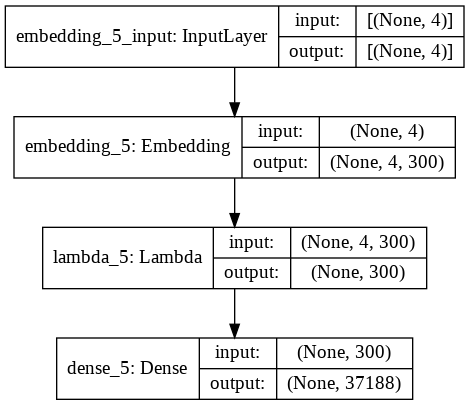

In [124]:
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [125]:
google_drive_path = '/content/drive/MyDrive/weights/cbow/now_1000.h5'

In [127]:
early_stopping_cb = callbacks.EarlyStopping(monitor='loss', patience=4, verbose=True)
checkpoint_cb = callbacks.ModelCheckpoint(google_drive_path, monitor='loss', verbose=True, save_best_only=True)
tensorboard_callback = callbacks.TensorBoard(log_dir="logs")

callbacks_list = [early_stopping_cb, checkpoint_cb, tensorboard_callback]

history = model.fit(dataset, epochs=1, callbacks=callbacks_list)

613/613 [==============================] - 319s 520ms/step - loss: 8.0322 - accuracy: 0.0707

Epoch 00001: loss improved from inf to 8.03216, saving model to /content/drive/MyDrive/weights/cbow/now_1000.h5
